<a href="https://colab.research.google.com/github/samyff12/LATAM/blob/main/IMAE_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actualizacion IMAE LATAM**

### Paquetes y meses

In [239]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import urllib.request as urllib2
import re
!pip install pymupdf
!pip install tabula-py
import tabula as tb
import fitz  # this is pymupdf
import matplotlib.pyplot as plt
import seaborn as sns

In [240]:
#html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
 #                   '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
 #                   '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual')
#soup = BeautifulSoup(html.text,'lxml')
#table = soup.find_all('p', class_='text-right')
#tablec = soup.find_all('th', colspan='1')

#indicadores=[]
#paises =[]
#for i in range(len(table)):
 # ind = float(table[i].text)
#  pais = tablec[i].text
#  indicadores.append(ind)
 # paises.append(pais)

#imae_latam =  pd.DataFrame(indicadores,index = paises,columns = ['IMAE'])
#print(f'IMAE a {fecha}')
#imae_latam

In [241]:
meses = [0,[1,'Enero'],[2,'Febrero'],[3,'Marzo'],[4,'Abril'],[5,'Mayo'],[6,'Junio'],[7,'Julio'],[8,'Agosto'],
         [9,'Septiembre'],[10,'Octubre'],[11,'Noviembre'],[12,'Diciembre']]
mes3 = {'ene':'Enero','feb':'Febrero','mar':'Marzo','abr':'Abril','may':'Mayo','jun':'Junio','jul':'Julio',
        'ago':'Agosto','sep':'Septiembre','oct':'Octubre','nov':'Noviembre','dic':'Diciembre'}

### import calendar

# d = dict((v,k) for k,v in enumerate(calendar.month_abbr))
# d

## Para obtener las series de todo el año 2021-2022


### **SECMCA**

html = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/444/' +
                    '20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
                    '-&all_vars=2|IMAE,%20variaci%C3%B3n%20interanual').text
soup = BeautifulSoup(html,'lxml')

In [242]:
# INDICE VERSION
html1 = requests.get('http://www.secmca.org/chart/?parent=Producci%C3%B3n&scid=2&cid=1&scsid=0&son=%C3%8Dndice%20Mensual%20de%20la%20Actividad%20Econ%C3%B3mica&url=11/14/3-13-50-17-4-52-161/39/265/19-258/81/' +
  '20201-20202-20203-20204-20205-20206-20207-20208-20209-202010-202011-202012-20211-20212-20213-20214-20215-20216-20217-20218-20219-202110-202111-202112-20221-20222-20223-20224-20225-20226-20227-20228-20229-202210-202211-202212' +
  '-&all_vars=1|IMAE').text
soup1 = BeautifulSoup(html1,'html.parser')

tabpais = soup1.find_all('th', colspan='1')
table = soup1.find_all('p', class_='text-left')
fechas = []
for i in range(len(table)):
  x = re.sub(" ","",table[i].text)
  fechas.append(x.replace("\n","").replace('Setiembre','Septiembre'))

paises = [tabpais[i].text for i in range(len(tabpais))]
fechas[-1]

'2021-Julio'

In [243]:
#INDICE
table1 = soup1.find_all('p', class_='text-right')
matriz = np.array([])
for i in table1:
  matriz = np.array(np.append(matriz,i))
matriz = np.where(matriz=="--", np.nan, matriz).astype(np.float)
matriz = matriz.reshape(-1,7) # 7 paises
imaeLA = pd.DataFrame(matriz,index=fechas,columns=paises)
imaeLA

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá
2020-Enero,104.05,110.79,127.40,243.16,152.64,179.04,345.73
2020-Febrero,105.21,110.06,125.54,242.62,144.15,183.24,338.73
2020-Marzo,103.60,105.56,121.36,218.18,140.09,165.67,364.78
2020-Abril,90.89,88.28,112.77,186.17,124.74,125.35,247.19
2020-Mayo,93.16,89.87,111.25,188.50,133.91,158.43,228.30
2020-Junio,96.96,96.97,111.07,208.25,128.96,160.89,243.01
2020-Julio,92.70,96.05,117.42,208.89,147.98,162.35,241.95
2020-Agosto,93.22,102.57,120.25,225.75,138.85,169.07,251.35
2020-Septiembre,98.05,106.44,121.45,230.48,140.18,163.68,268.97
2020-Octubre,101.93,106.63,125.71,249.74,148.35,175.09,312.12


import re
tabpais = soup.find_all('th', colspan='1')
table = soup.find_all('p', class_='text-left')
fechas = []
paises =[]
for i in range(len(table)):
  x = re.sub(" ","",table[i].text)
  fechas.append(x.replace("\n",""))
  pais = tabpais[i].text
  #indicadores.append(ind)
  paises.append(pais)
fechas[-1]

table1 = soup.find_all('p', class_='text-right')
matriz = np.array([])
for i in table1:
  matriz = np.array(np.append(matriz,i))
matriz = np.where(matriz=="--", np.nan, matriz).astype(np.float)
matriz = matriz.reshape(-1,7) # 7 paises
imaeLA = pd.DataFrame(matriz,index=fechas,columns=paises)
imaeLA

### **Argentina**


#### Publicaciones disponibles las fechas: 
1. 28 sept 
2. 21 Oct
3. 23 Nov
4. 23 Dic

In [244]:
url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
urllib2.urlretrieve(url, "test.xls")
data = pd.read_excel('test.xls',header=2)
data1 = data.iloc[:,:4].dropna(subset = ['Período'])
data1.reset_index(drop=True,inplace=True)
data1['Unnamed: 0'] = data1['Unnamed: 0'].ffill() # forward fill

In [245]:
data1['fecha'] = data1['Unnamed: 0'].astype('str') +"-"+ data1['Período']
data1.set_index(data1.fecha,inplace=True)
imaeLA = pd.merge(imaeLA,data1.iloc[:,2],how='left',left_index=True,right_index=True)
imaeLA.columns = [*imaeLA.columns[:-1], 'Argentina']
#imaeLA

### **Brasil**

#### Publicaciones :
1. 15 sept
2. 15 Oct
3. 16 Nov
4. 15 Dic

In [246]:
urljson = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=json"
urllib2.urlretrieve(urljson, "brasil.json")
bra = pd.read_json('brasil.json')
bra.rename(columns={'valor':'Brasil'},inplace=True)

bra['Brasil1'] = bra.Brasil.pct_change(12)*100 # calculo tasa de crecimiento
bra['date'] = pd.to_datetime(bra['data'],format='%d/%m/%Y') # transformamos a formato fecha
# Creamos indice
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+pd.DatetimeIndex(bra['date']).month.astype(str)

nombre_mes = [meses[i][1] for i in pd.DatetimeIndex(bra['date']).month.tolist()] # obtenemos nombre del mes
bra['fecha'] = pd.DatetimeIndex(bra['date']).year.astype(str) +"-"+ nombre_mes # creamos indice
bra.set_index(bra.fecha,inplace=True) #reemplazamos indice

imaela = pd.merge(imaeLA,bra['Brasil'],how='left',left_index=True,right_index=True) # combinamos la data
bra.tail(1)

,data,Brasil,Brasil1,date,fecha
fecha,,,,,
2021-Julio,01/07/2021,143.35,5.528563,2021-07-01,2021-Julio


In [247]:
 #    imaela

### **Mexico**

#### Publicaciones disponibles las fechas: 
1. 27 sept 
2. 25 Oct
3. 25 Nov
4. 24 Dic

In [248]:
url = "https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_1.xlsx"
urllib2.urlretrieve(url, "test.xlsx")
mex = pd.read_excel('test.xlsx',header=3,nrows=3)
mex = mex.T.reset_index(drop=True) # transponemos y estandarizamos el indice
mex.drop(0,inplace=True) # borramos primera fila
mex[2] = round(mex[2].astype(float),2) # leyendo tasas de crecimiento en el formato numerico y redondeando
mex[0] = mex[0].ffill()

In [249]:
mex[1] = mex[1].replace(['oR','oP','lR','lP','eR','eP'],['o','o','l','l','e','e'], regex=True) #limpiar superindices "Revisado" "Preliminar"
mex[0] = mex[0].replace('P','',regex=True) # limpiar preliminar de fecha
mex.index = mex[0].astype('str') +"-"+ mex[1] #creamos indice para base de datos
mex.columns = [*mex.columns[:-1], 'México'] # nombramos columna
mex.dropna().tail(1) # mostrar ultimo valor no nulo

,0,1,México
2021-Junio,2021,Junio,110.85


In [250]:
imaela = round(pd.merge(imaela,mex['México'],how='left',left_index=True,right_index=True),2) # combinamos las series

In [ ]:
imaela

In [ ]:
## link excel
#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_1.xlsx       indice

#https://www.inegi.org.mx/contenidos/temas/economia/cn/igae/tabulados/ori/IGAE_2.xlsx       crecimiento

### **Chile**

#### Publicaciones disponibles las fechas:
 
2. 1 Oct  - Agosto
3. 2 Nov  - Septiembre
4. 1 Dic - Noviembre

In [252]:
url = "https://si3.bcentral.cl/estadisticas/Principal1/excel/CCNN/IMACEC/Excel/IMACEC.xlsx"
urllib2.urlretrieve(url, "chile.xlsx")
df = pd.read_excel('chile.xlsx',header=5,keep_default_na=False)

In [254]:
chile = df.loc[1:,[df.columns[0],df.columns[1],'Imacec']][:-10] # excluimos las ultimas 10 filas (pie de pagina)
chile.rename(columns = {'Imacec':'Chile'}, inplace = True) # renombramos
chile['Chile1'] = pd.to_numeric(chile.Chile).pct_change(12)*100
###
chile[chile.columns[0]] = pd.to_numeric(chile[chile.columns[0]], errors='coerce').ffill().bfill().astype(int)
 # las columnas del excel contienen string en blanco por lo que se transformaron a numero antes de hacer el forward fill
 # el backward fill es para asegurar que no quede NaN por detras y dificulte la creacion del indice
###

chile['mes'] = chile[chile.columns[1]].map(mes3).bfill() # creando mes y usando el bfill por el mismo motivo explicado arriba

#Creamos el indice
chile.index = chile[chile.columns[0]].astype('str') +"-"+ chile.mes

chile.tail(1)

,,Unnamed: 1,Chile,Chile1,mes
2021-Julio,2021,jul,113.471,18.075599,Julio


In [268]:
imaelatam = round(imaela.merge(chile['Chile'],how='left',left_index=True,right_index=True),2)
imaelatam = imaelatam[~imaelatam.index.duplicated(keep='last')].reindex(imaela.index) # hay duplicados, los eliminamos y reindexamos

In [ ]:
#  imaelatam

### **Ecuador**

#### Publicaciones disponibles las fechas: 
1. 14 sept    -    Julio
2. 13 Oct    -     Agosto
3. 15 Nov    -     Sep
4. 24 Dic    -     Oct

In [272]:
url = "https://contenido.bce.fin.ec/documentos/PublicacionesNotas/Catalogo/IEMensual/Adelantos/IEM-452-e.xlsx"
urllib2.urlretrieve(url, "Ecuador.xlsx")
df = pd.read_excel('Ecuador.xlsx',header=7,keep_default_na=False)[1:13].reset_index()

ecu = (df.set_index(['Unnamed: 0','index'])
.stack()
.reset_index()
.rename(columns={'Unnamed: 0':'mes','level_2':'Year'})).sort_values(['Year','index']) # ingenieria de base de datos

# Elaboracion de indice
ecu['Mes'] = ecu.mes.str.lower().map(mes3)
ecu.insert(3, 'fecha', ecu.Year.astype(str) + '-' + ecu.Mes)
ecu.index = ecu.fecha

# Variacion interanual
ecu.rename(columns={0:'Ecuador'},inplace=True)
ecu['Ecuador1'] = pd.to_numeric(ecu['Ecuador'],errors='coerce').pct_change(12)*100

In [275]:
imaela = round(pd.merge(imaelatam,ecu['Ecuador'],how='left',left_index=True,right_index=True),2)

In [ ]:
#    imaela

df = np.array(tb.read_pdf('ecuador.pdf',pages = '5',stream=True,multiple_tables=True,pandas_options={'header':None}))
dff = pd.DataFrame(df.reshape(-1,5)) # en 2022 el reshape debe ser (-1,6)

dff[dff.iloc[3,2].split(' ')] = dff[2].str.split(' ',expand=True)
if dff.iloc[3,3] in range(2020,2040,1):
  dff[int(dff.iloc[3,3])] = dff[3]
  dff[int(dff.iloc[3,4])] = dff[4]
else:
  dff[int(dff.iloc[3,4])] = dff[4]

if dff.iloc[18,0] in ['Ene']:
    ecu = dff.iloc[18:30,[0,-3,-2,-1]].reset_index(drop=True)
else:
    ecu = dff.iloc[19:31,[0,-3,-2,-1]].reset_index(drop=True)
 
ecu['interanualAnterior'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100
ecu['Ecuador'] = ecu.iloc[:,-2].astype(float)/ecu.iloc[:,-3].astype(float)*100-100

listames = [meses[1:][i][1] for i in range(len(meses[1:]))]
ecu['mes'] = listames

ecu.index = str(ecu.columns[-4]) + '-' + ecu.mes
ecu.dropna().tail(1)

### **Colombia**

#### Publicaciones disponibles las fechas: 
1. 17 sept    -    Julio
2. 19 Oct    -     Agosto
3. 16 Nov    -     Sep
4. 17 Dic    -     Oct

In [277]:
url = 'https://www.dane.gov.co/index.php/estadisticas-por-tema/cuentas-nacionales/indicador-de-seguimiento-a-la-economia-ise/historicos-ise-comunicados-y-boletines'

header= {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 
      'AppleWebKit/537.11 (KHTML, like Gecko) '
      'Chrome/23.0.1271.64 Safari/537.11',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
      'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
      'Accept-Encoding': 'none',
      'Accept-Language': 'en-US,en;q=0.8',
      'Connection': 'keep-alive'}

req = urllib2.Request(url=url, headers=header) 
page = urllib2.urlopen(req).read()


In [278]:
soupco = BeautifulSoup(page,'lxml')
links = [a['href'] for a in soupco.select("a[href*=2021]")] # extraemos links que contengan 2021 
 # ultimos link disponibles

In [279]:
url2 = 'https://www.dane.gov.co' + links[0] # si esta el nuevo mes restarle 1 al indice de links
urllib2.urlretrieve(url2, "colombia.pdf")

('colombia.pdf', <http.client.HTTPMessage at 0x7efc4289ba10>)

In [ ]:
# url = 'https://www.dane.gov.co/files/investigaciones/boletines/pib/bol_ISE_' + input('Mes en formato Mmm: ') + '2021.pdf'

# urllib.request.urlretrieve(url, "colombia.pdf")

In [280]:
df = np.array(tb.read_pdf('colombia.pdf',pages = '17',stream=True,multiple_tables=True,pandas_options={'header':None}))
dco = pd.DataFrame(df.reshape(-1,4))
dco = dco.loc[:,0:2]
dco.tail(1)

Got stderr: Sep 16, 2021 4:03:38 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider loadDiskCache
Sep 16, 2021 4:03:38 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>
Sep 16, 2021 4:03:38 PM org.apache.pdfbox.pdmodel.font.FileSystemFontProvider <init>



,0,1,2
31,Junio,"110,05","14,47 8,59"


In [342]:
dco[3] = dco[2].str.split(' ',expand=True)[0] # Tomando las tasas de crecimiento de la tabla pdf
dco.rename(columns={1:'Colombia'},inplace=True)
dco['Colombia1'] = pd.to_numeric(dco[3].str.replace(',','.'),errors='coerce')  #Convirtiendo la data a numero
dco['Colombia'] = pd.to_numeric(dco['Colombia'].str.replace(',','.'),errors='coerce')

In [282]:
split = dco[0].str.split(' - ')     # extraer mes 
fech = []
for i in range(len(split)):
  if type(split[i]) == float:
    fech.append('0')
  elif len(split[i]) == 1 :
    fech.append(str(split[i][0]))
  else:
    fech.append(str(split[i][1].capitalize()))

In [283]:
anof=[]                          # extraer año
for i in range(len(split)):
  if type(split[i]) == float:
    anof.append('0')
  elif len(split[i]) > 1 :
    anof.append(str(split[i][0]))
  else:
    anof.append(np.nan)

In [284]:
dco['mes'] = fech
dco['ano'] = anof
dco['ano'] = dco.ano.replace(['p','r',' '],['','',''],regex=True).ffill()
dco.index = dco['ano'] + '-' + dco['mes'] # creamos indice

In [343]:
imaela = imaela.merge(dco['Colombia'],how='left',left_index=True,right_index=True).reindex(imaela.index)

In [ ]:
#  imaela

### **Paraguay**

In [291]:
url = 'https://www.bcp.gov.py/indicador-mensual-de-actividad-economica-del-paraguay-imaep-i471'

#the URL where you are requesting at
req = urllib2.Request(url=url, headers=header) 
page = urllib2.urlopen(req).read()

In [292]:
souppy = BeautifulSoup(page,'lxml')
links = [a['href'] for a in souppy.select("a[href*=_2021]")] # extraemos links que contengan _2021 
 # ultimos link disponibles

In [319]:
#for mes in range(len(links)):
#  linkurl = 'https://www.bcp.gov.py/' + links[-(mes+1)]
#  urllib2.urlretrieve(linkurl, mes)
url2 = 'https://www.bcp.gov.py/' + links[0] # -(numero mes)
opener = urllib2.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib2.install_opener(opener)
urllib2.urlretrieve(url2, "py.pdf")

with fitz.open("py.pdf") as doc:
    text = ""
    for page in doc:
        text += page.getText()

fechapy = text.split(' |',2)[1] # con el espacio
fechapy = fechapy.split(' ')[1] +'-'+fechapy.split(' ')[0]

# Debido a que las tasas son iguales en Enero
if 'Enero' not in fechapy:
  valorpyinteranual = text.split('variación de ',1)[1][0:4] # para obtener tasa interanual
  valorpyacum = text.split('% a',1)[0][-4:] # para obtener tasa acumulada interanual
  valorpyinteranual = float(valorpyinteranual.replace(',','.').replace('%',''))
  valorpyacum = float(valorpyacum.replace(',','.').replace(' ',''))
else:
   valorpyinteranual = text.split('variación de ',1)[1][0:4]
   valorpyinteranual = float(valorpyinteranual.replace(',','.').replace('%',''))
   valorpyacum = valorpyinteranual

print(fechapy)
print(valorpyinteranual,' Tasa interanual')
print(valorpyacum, ' Tasa acumulada interanual')

2021-Julio
3.0  Tasa interanual
6.0  Tasa acumulada interanual


In [324]:
#Añadir nuevo mes cuando salga##IMPORTANTE
py = pd.DataFrame({'Fecha':['2021-Enero','2021-Febrero','2021-Marzo','2021-Abril','2021-Mayo','2021-Junio','2021-Julio'],
                   'Paraguay_a':[-5.6,-3.0,0.7,4.7,6.3,6.3,6.0],
                   'Paraguay_i':[-5.6,-0.5,8.0,19.3,12.4,6.6,3.0]})
dic = {'Fecha':fechapy,'Paraguay':valorpyinteranual}
py.append(dic,ignore_index=True)
py.index = py.Fecha

In [325]:
py

,Fecha,Paraguay_a,Paraguay_i
Fecha,,,
2021-Enero,2021-Enero,-5.6,-5.6
2021-Febrero,2021-Febrero,-3.0,-0.5
2021-Marzo,2021-Marzo,0.7,8.0
2021-Abril,2021-Abril,4.7,19.3
2021-Mayo,2021-Mayo,6.3,12.4
2021-Junio,2021-Junio,6.3,6.6
2021-Julio,2021-Julio,6.0,3.0


In [377]:
imaela['a'] = [imaela.index.str.split('-')[i][0] for i in range(len(imaela.index))]
imaela = imaela.apply(pd.to_numeric)

In [398]:
# Crecimiento interanual
imaela1 = imaela.pct_change(12,fill_method=None)*100
imaela1 = imaela1.merge(py['Paraguay_i'],how='left',left_index=True,right_index=True).reindex(imaela.index) #agregar PARAGUAY
imaela1.dropna(how='all',inplace=True) # NAs drop

In [404]:
# Crecimiento acumulado interanual
imaela2 = imaela.groupby('a').cumsum().pct_change(12,fill_method=None)*100
imaela2 = imaela2.merge(py['Paraguay_a'],how='left',left_index=True,right_index=True).reindex(imaela.index) #agregar PARAGUAY
imaela2.dropna(how='all',inplace=True) # NAs drop

In [ ]:
#!pip install selenium
#!apt-get update # to update ubuntu to correctly run apt install
#!apt install chromium-chromedriver
#!cp /usr/lib/chromium-browser/chromedriver /usr/bin
#import sys
#sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
#from selenium import webdriver
#chrome_options = webdriver.ChromeOptions()
#chrome_options.add_argument('--headless')
#chrome_options.add_argument('--no-sandbox')
#chrome_options.add_argument('--disable-dev-shm-usage')
#wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

## imae


In [468]:
imaela.drop('a',axis=1).tail(1)

,Costa Rica,El Salvador,Guatemala,Honduras,Nicaragua,República Dominicana,Panamá,Argentina,Brasil,México,Chile,Ecuador,Colombia_y
2021-Julio,105.76,NaN,129.87,NaN,NaN,181.91,NaN,NaN,143.35,NaN,113.470734,168.483106,NaN


In [ ]:
#@title Bar
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=imaela.drop('a',axis=1).iloc[-1:,:]);

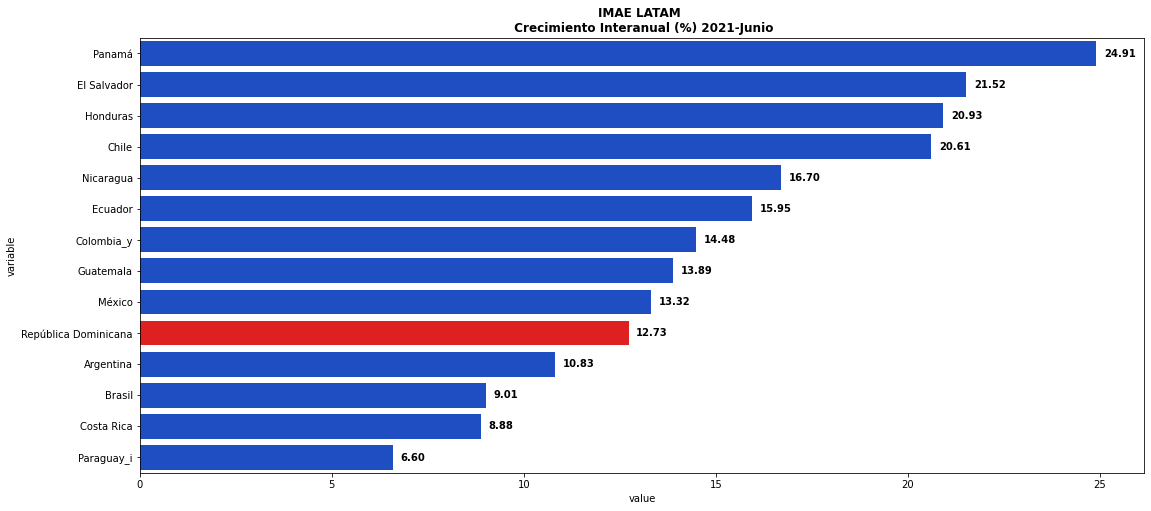

In [470]:
#@title Interanual Mes Anterior
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela1.drop('a',axis=1).iloc[-2:-1,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Interanual (%) {}'.format(imaela.index[-2]),weight='bold');

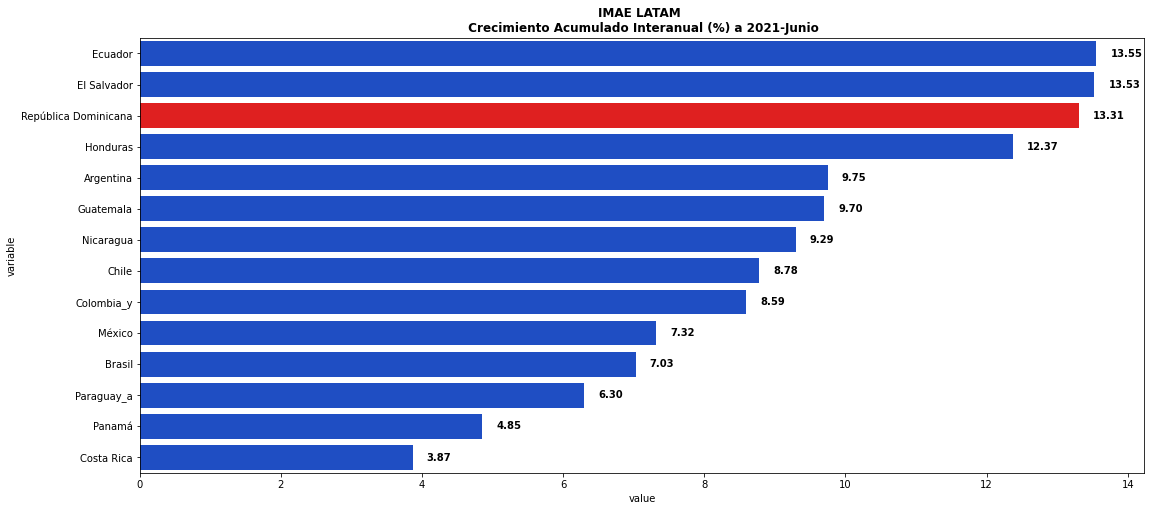

In [461]:
#@title Acumulado Interanual Mes Anterior
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela2.iloc[-2:-1,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Acumulado Interanual (%) a {}'.format(imaela.index[-2]) ,weight='bold');

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


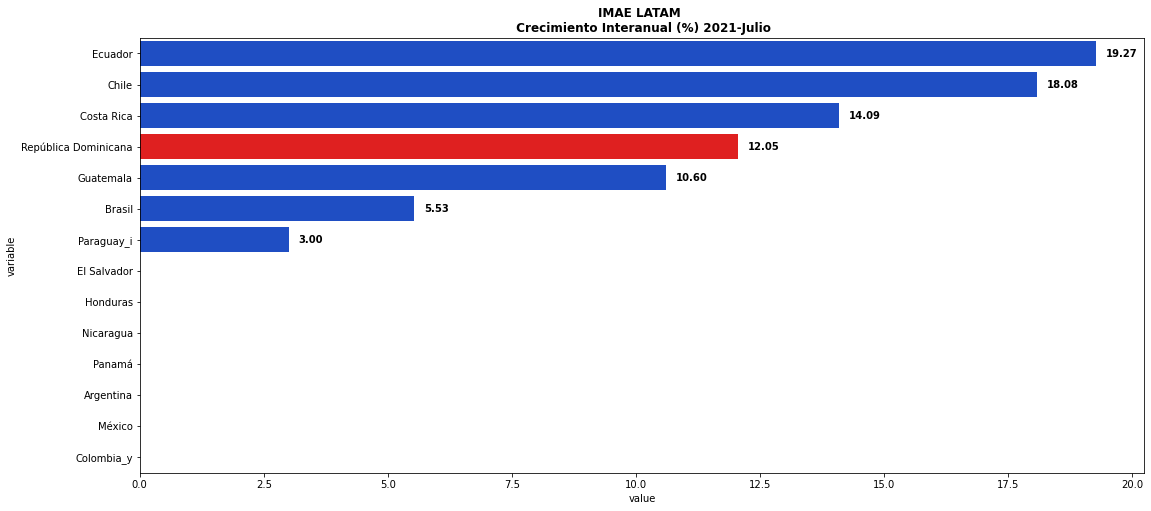

In [460]:
#@title Interanual Ultimo Mes
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela1.drop('a',axis=1).iloc[-1:,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Interanual (%) {}'.format(imaela.index[-1]),weight='bold');

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


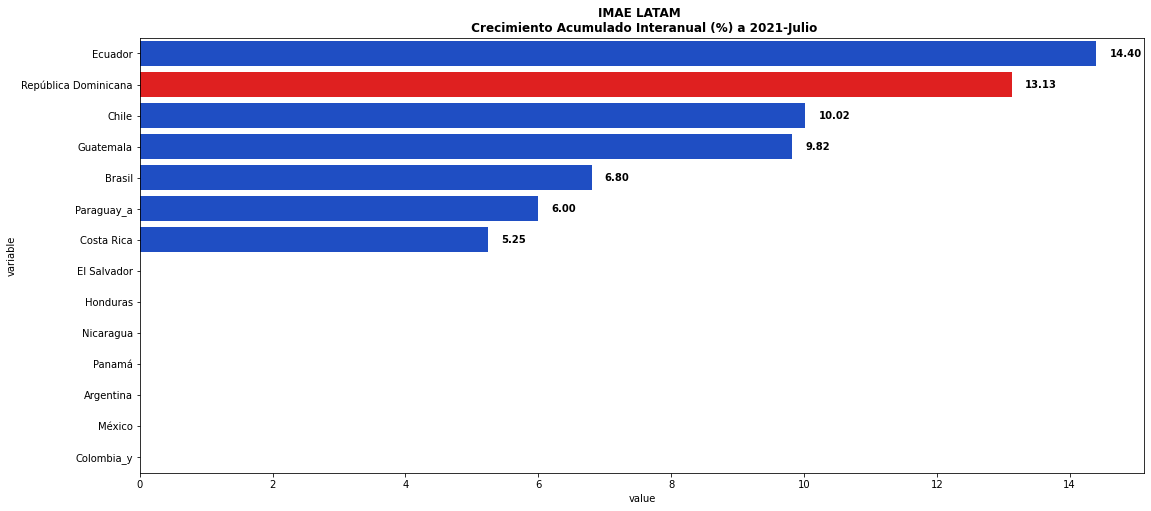

In [463]:
#@title Acumulado Interanual Ultimo Mes
f, ax = plt.subplots(figsize=(18, 8))
df = pd.melt(imaela2.iloc[-1:,:]).sort_values('value',ascending=False) 
sns.barplot(data = df ,x='value',y='variable',
                palette=['r' if y =='República Dominicana' else '#0343DF' for y in df.variable])
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width+0.2,       # set the text at 0.2 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center', weight="bold") # vertical alignment
plt.title('IMAE LATAM \n Crecimiento Acumulado Interanual (%) a {}'.format(imaela.index[-1]) ,weight='bold');